In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

#plot library
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import *

## Load Data 

In [4]:
PATH_TRAIN= '../data/train.csv'
PATH_TEST = '../data/test.csv'
y, tX, ids = load_csv_data(PATH_TRAIN, sub_sample=False)
y_test, tX_test, ids_test = load_csv_data(PATH_TEST, sub_sample=False)
features_name = np.genfromtxt('../data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [5]:
print("y train size : ", y.shape[0] )
print("train tX shape : ", tX.shape[0])
print( "y test size : ", y_test.shape[0])
print("test tX shape : ", tX_test.shape)

y train size :  250000
train tX shape :  250000
y test size :  568238
test tX shape :  (568238, 30)


In [6]:
print("# Higgs signal particules (s): ", len(y[y==1]), '/',round(len(y[y==1])*100/len(y),0),'%')
print("# background particules (b): ", len(y[y==-1]), '/',round(len(y[y==-1])*100/len(y),0),'%')

# Higgs signal particules (s):  85667 / 34.0 %
# background particules (b):  164333 / 66.0 %


In [7]:
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

There are 1580052 ( 21.0 %), missing values


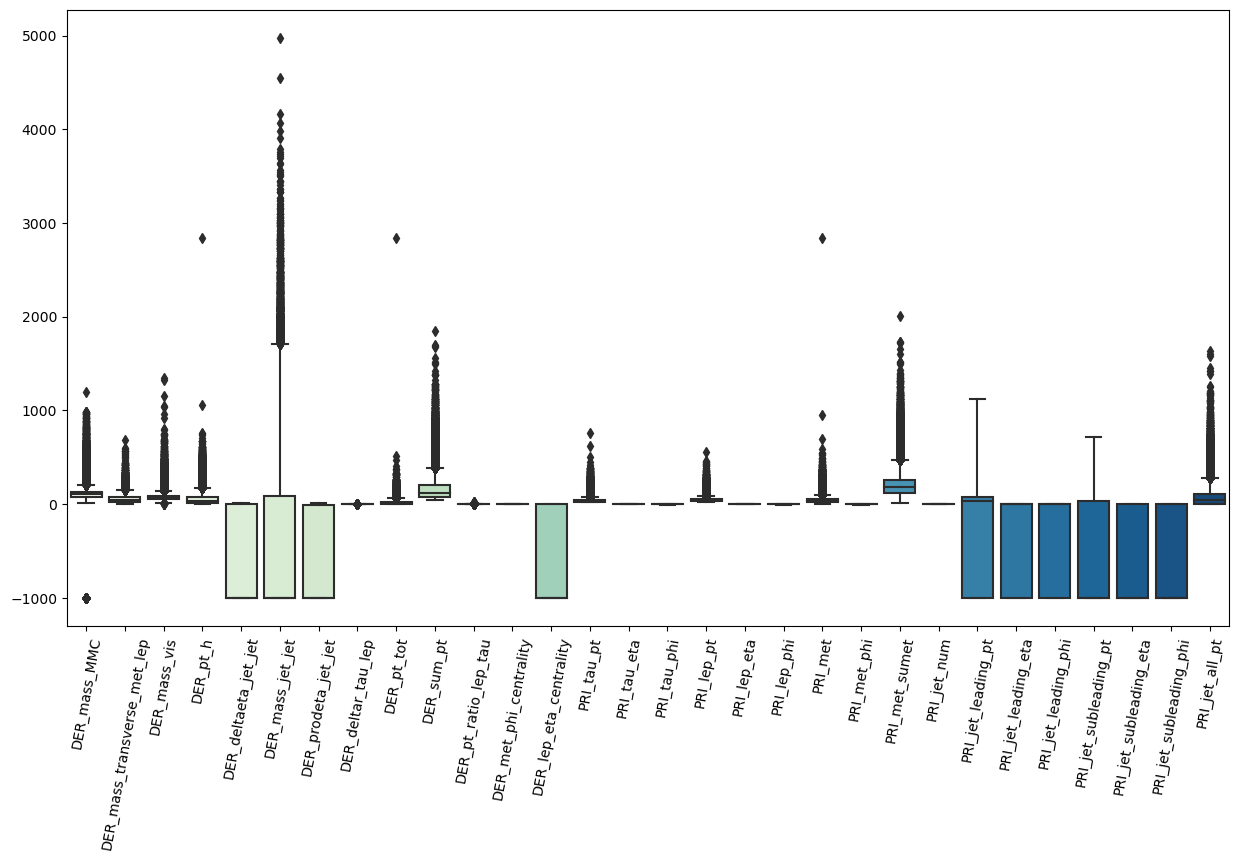

In [49]:
palette = sns.color_palette("GnBu", n_colors=30)


figure = plt.figure(figsize=(15,8))
ax = sns.boxplot(data = tX, palette = palette)
ax.set_xticklabels(features_name, rotation = 80)
plt.show()

*need to standarize the features + remove outliers*

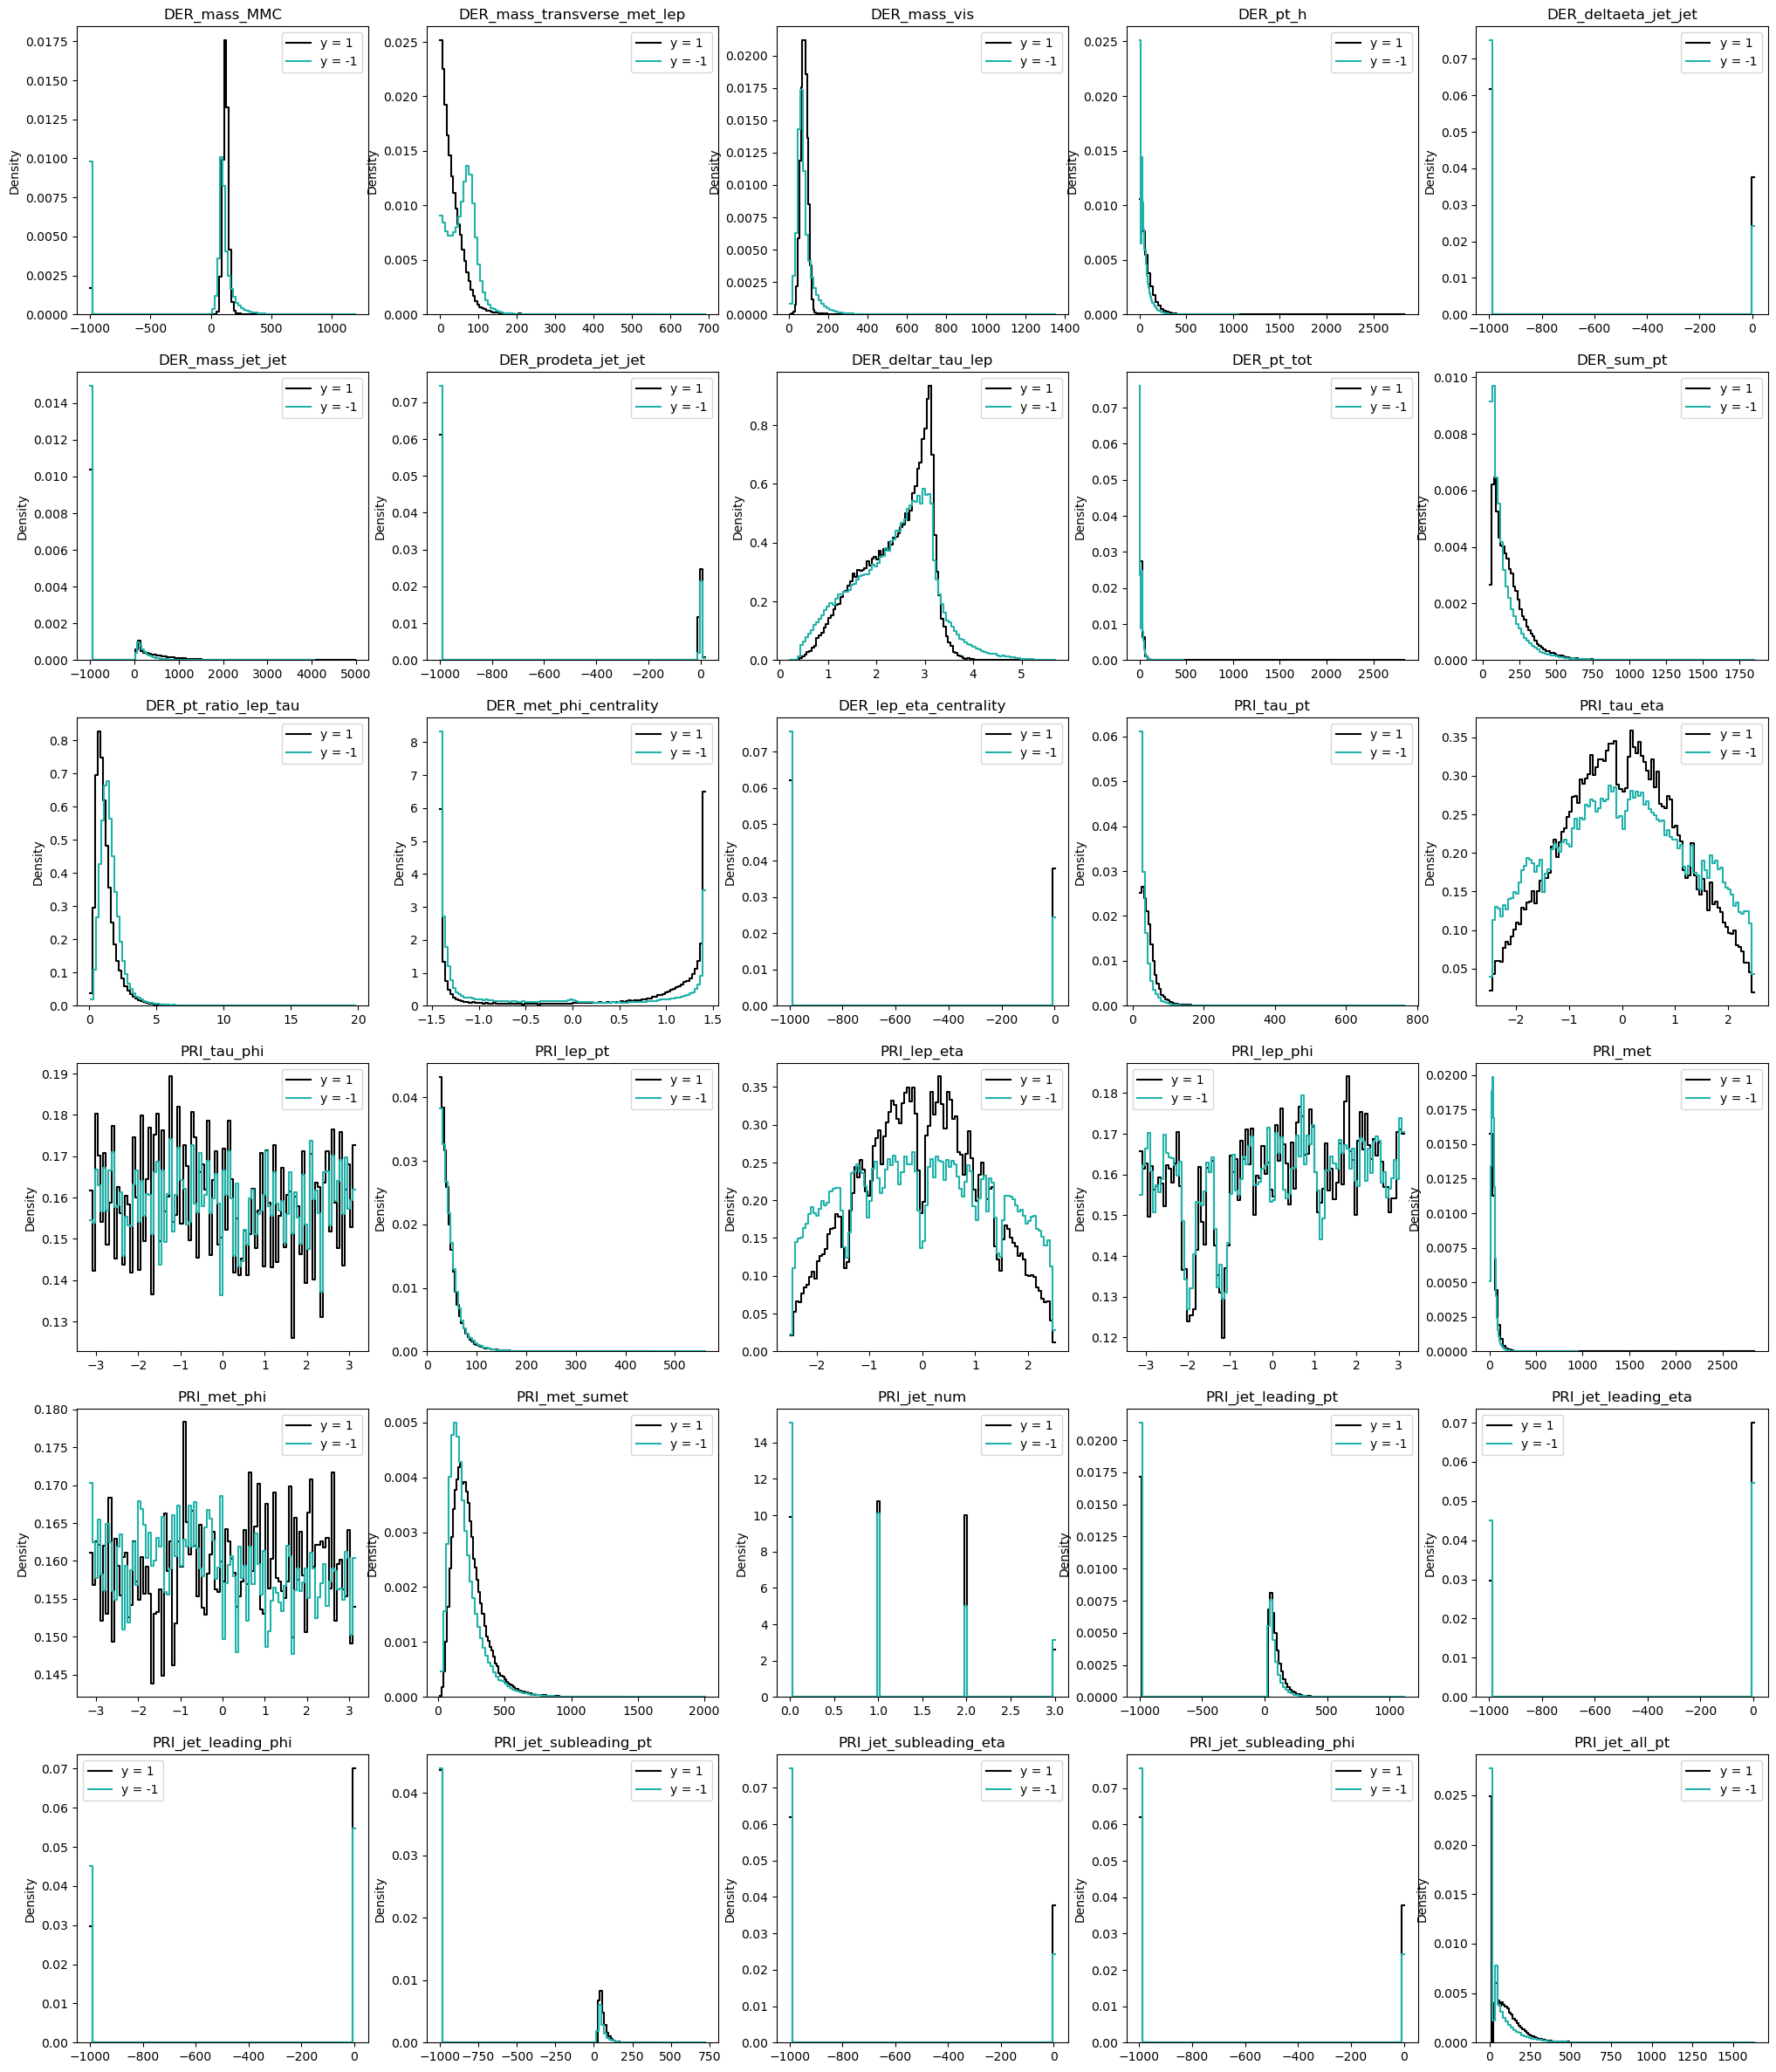

In [69]:
fig= plt.figure(figsize=(25,30))


for idx in range(tX.shape[1]): 
    
    ax=plt.subplot(6,5,idx+1)
    
    #density plot of each feature depending on the y response
    sns.histplot(data=tX[y==1, idx], ax=ax, element="step", 
                 fill=False, color = 'black', stat = 'density', bins = 100)
    sns.histplot(data=tX[y==-1, idx], ax=ax, element="step",
                 fill=False, color = 'lightseagreen', stat = 'density', bins = 100)
    
    #plot parameters
    ax.set_title(features_name[idx])
    ax.legend(["y = 1", "y = -1"])
    
    

*NB : test without PRI_tau_phi, PRI_met_phi, PRI_lep_phi*

## Data Preprocessing
remove outliers, missing values, unwanted features, feature scaling 

In [102]:
from preprocessing import *

In [131]:
print('Missing values process')
tX, tX_test = missing_values(tX, tX_test, 0.8)
print('Train size ', tX.shape, 'Test size', tX_test.shape)
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

print('Standarization')
tX = standarize(tX)
tX_test= standarize(tX_test)




Missing values process
Train size  (250000, 30) Test size (568238, 30)
Standarization
